# From Technically Correct to Consistent Data

(*from de Jonge van der Loo*)

Consistent data is technically correct data that is ready for statistical analysis. 

This implies that data with missing values, special values, errors and outliers are, either:
* removed,
* corrected, or
* imputed

The data is consistent with constraints based on real-world knowledge about the subject that the data describe.

Consistency can be understood to include:
* **in-record consistency:** no contradictory information is stored in a single record
* **cross-record consistency:** meaning that statistical summaries of different variables do not conflict with each other
* **cross-dataset consistency:** meaning that the dataset that is currently analyzed is consistent with other datasets pertaining to the same subject matter

We mainly Will focus on methods dealing with **in-record consistency**, with the exception of outlier handling which can be considered a cross-record consistency issue.

The process towards consistent data always involves the following 3 steps:

1. **Detection** of an inconsistency: find which constraints are violated. For example, an age variable is constrained to non-negative values.
2. **Selection** of the field or fields causing the inconsistency. This is trivial in the case of a univariate demand as in the previous step, but may be more cumbersome when cross-variable relations are expected to hold. For example the marital status of a child must be unmarried. In the case of a violation it is not immediately clear whether age, marital status or both are wrong.
3. **Correction** of the fields that are deemed erroneous by the selection method. This may be done through deterministic (model-based) or stochastic methods

The execution of three steps won't be always neated divided in different code executions. They can be used all in one execution. However, it is important to keep in mind the process towards Consistent Data.

## Detection and Localization of Errors

This is the first step towards consistency satisfaction: to detect all localize errors.

### Missing Values

A missing value, represented by (np.nan in Pandas), is a placeholder for a datum of which **the type is known but its value isn't** (technically correct but not consistent). 

Therefore, **it is impossible to perform statistical analysis on data where one or
more values in the data are missing**.

We have two options:
1. omit elements from a dataset that contain missing values
2. impute a value

** Missingness is something to be dealt with prior to any analysis.**

In practice, analysts, but also commonly used numerical software may confuse a missing value
with a default value or category.

In Pandas however, there's an [explanation](http://pandas.pydata.org/pandas-docs/stable/missing_data.html#calculations-with-missing-data) of how NA's are treated in each method

In [11]:
import numpy as np
import pandas as pd

s1 = pd.Series([0.9,0.6,np.nan,0.12])
s2 = pd.Series([0.9,0.6,0,0.12])
s3 = pd.Series([0.9,0.6,0.12])

print s1.mean(), s2.mean(), s3.mean()

0.54 0.405 0.54


In [15]:
s1.sum(), s2.sum(), s3.sum()

(1.62, 1.62, 1.62)

In [16]:
np.nan + 2

nan

It should be **up to the analyst to decide how empty values are handled**, since a **default imputation** may yield unexpected or **erroneous results** for reasons that are hard to trace.

Pandas is not consistent with this treatment in contraposition with R, where most of the methods provide to the analysis the option of how to handle NA.

We already learnt how to deal with NaN:

In [57]:
df = pd.DataFrame({"one":np.random.normal(0,1,5),
                    "two":np.random.normal(0,1,5),
                  "three":np.random.normal(0,1,5)})
df.iloc[0,0] = np.nan
df.iloc[1,1] = np.nan
df.iloc[2,2] = np.nan

print df.isnull().any(axis=1)
df.loc[-df.isnull().any(axis=1),:]

0     True
1     True
2     True
3    False
4    False
dtype: bool


,one,three,two
3,-0.419701,-1.407426,-1.12682
4,-0.680209,0.516218,-0.12596


In [56]:
#to check where is a null
nulls = df.isnull().sum(axis=1)
print nulls
# to see whic columns have nans
print df.isnull().sum()

0    1
1    1
2    1
3    0
4    0
dtype: int64
one      1
three    1
two      1
dtype: int64


## Special Values

There's another special kind of variables that we haven't talked yet.

As Pandas relies over NumPy, it provides a special value to deal with infinite which is np.inf and -np.inf.

0         inf
1    1.000000
2    0.500000
3    0.333333
4    0.250000
dtype: float64


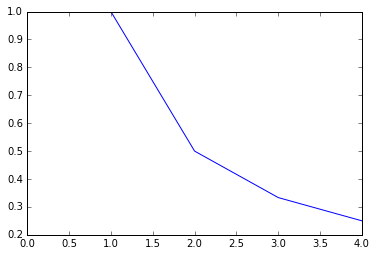

In [34]:
import matplotlib.pyplot as plt

s = pd.Series([0,1,2,3,4])
print 1/s

%matplotlib inline

(1/s).plot()

In [39]:
(1/s)[(1/s).map(lambda x: np.isfinite(x))]

1    1.000000
2    0.500000
3    0.333333
4    0.250000
dtype: float64

We have seen also pd.NaT value for timedeltas. We can deal with these values in the following way:

In [42]:
pd.isnull(pd.NaT)

True

In [44]:
pd.isnull(pd.Series([pd.NaT,np.nan,None]))

0    True
1    True
2    True
dtype: bool

*(from [Pandas API Docs](http://pandas.pydata.org/pandas-docs/stable/missing_data.html#values-considered-missing))*

One has to be mindful that in python (and numpy), the nan's don’t compare equal, but None's do. 

Note that Pandas/numpy uses the fact that np.nan != np.nan, and treats None like np.nan.

In [45]:
None == None, np.nan == np.nan

(True, False)

In [49]:
s = pd.Series([None,np.nan])
print (s == None).sum()
print (s == np.nan).sum()
print (s.isnull()).sum()

0
0
2


## Outliers

There is a vast body of literature on outlier detection, and several definitions of
outlier exist. 

A general definition: an outlier in a data set as an observation (or set of observations) which appear to be inconsistent with that set of data. 

Note that:

* Outliers do not equal errors
* They should be detected, but not necessarily removed
* Their inclusion in the analysis is a statistical decision

Let's see an example (data taken from [here](http://socr.ucla.edu/docs/resources/SOCR_Data/SOCR_Data_Dinov_020108_HeightsWeights.html)):

In [59]:
hw_df = pd.read_csv("../data/heigths_weights_dummy.tsv",sep="\t",index_col=0)
hw_df.isnull().any(axis=1).sum()

hw_df.columns = ["height","weight"]
hw_df["height"] = hw_df["height"] * 2.54
hw_df["weight"] = hw_df["weight"] * 0.453592
hw_df.describe()

,height,weight
count,33.000000,33.000000
mean,175.076991,63.547079
std,14.389248,28.916631
min,153.107034,35.386871
25%,170.476062,54.733677
50%,172.472731,58.841950
75%,176.272800,64.342071
max,246.768112,218.800216


We have a dataset with weights and heights of people. Using describe we can see that:
* height average is 175.07 cm
* weight average is 63.54 kg
    
However we have two (max) values (maybe not the same), that clearly overpass the mean: 246.76 and 218.80 respectively.

These values are considered outliers.

For more or less unimodal and symmetrically distributed data, Tukey's box-and-whisker
method for outlier detection is often appropriate. 

In this method, an observation is an outlier when it is larger than the so-called "whiskers" of the set of observations. 
The upper whisker is computed by adding 1.5 times the interquartile range (IQR) to the third quartile and rounding to the nearest lower observation. 

The lower whisker is computed likewise

** What is the IQR?**

* Quantiles are cutpoints dividing the range of a probability distribution into contiguous intervals with equal probabilities
* A percentile (or a centile) is a measure used in statistics indicating the value below which a given percentage of observations in a group of observations fall
* The 25th percentile is also known as the first quartile (Q1), the 50th percentile as the median or second quartile (Q2), and the 75th percentile as the third quartile (Q3)
* In general, percentiles and quartiles are specific types of quantiles

In [145]:
print hw_df.quantile([.25,.5,.75])

iqr_func = lambda x: x.iloc[1] - x.iloc[0] 

iqr = hw_df.quantile([.25,.75]).apply(iqr_func)
print "IQR"
print high_out
print low_out

high_out = hw_df.quantile([.75]) + iqr*1.5 
low_out = hw_df.quantile([.25]) - iqr*1.5

          height     weight
0.25  170.476062  54.733677
0.50  172.472731  58.841950
0.75  176.272800  64.342071
IQR
          height     weight
0.75  184.967905  78.754662
          height     weight
0.25  161.780957  40.321086


            height     weight
Index                        
31      190.888112  35.386871
33      246.768112  54.733677
            height     weight
Index                        
23      161.242121  44.407523
32      153.107034  77.529759


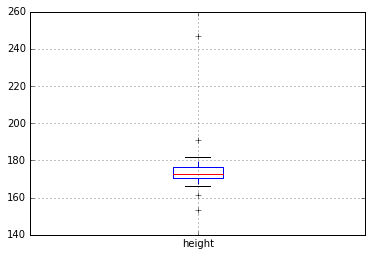

In [143]:
print hw_df[hw_df["height"] > high_out.loc[0.75,"height"]]
print hw_df[hw_df["height"] < low_out.loc[0.25,"height"]]

hw_df.boxplot(column=["height"],return_type="axes")

            height      weight
Index                         
9       172.472731  218.800216
            height     weight
Index                        
31      190.888112  35.386871


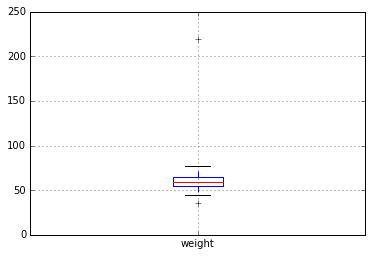

In [141]:
print hw_df[hw_df["weight"] > high_out.loc[0.75,"weight"]]
print hw_df[hw_df["weight"] < low_out.loc[0.25,"weight"]] 

hw_df.boxplot(column=["weight"],return_type="axes")

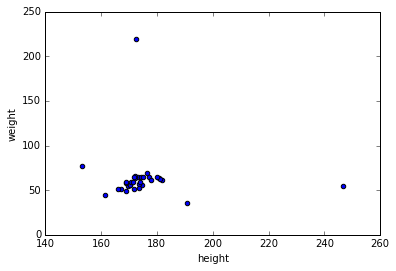

In [144]:
hw_df.plot(kind="scatter",x="height",y="weight")

### Types of Outliers

(*from https://www.analyticsvidhya.com/blog/2016/01/guide-data-exploration/#three*)

Whenever we come across outliers, the ideal way to tackle them is to find out the reason of having these outliers. 

The method to deal with them would then depend on the reason of their occurrence. Causes of outliers can be classified in two broad categories:

* **Artificial (Error) / Non-natural**
* **Natural.**

Let’s understand various types of outliers in more detail:

* **Data Entry Errors:**- Human errors such as errors caused during data collection, recording, or entry can cause outliers in data. For example: Annual income of a customer is \$ 100,000. Accidentally, the data entry operator puts an additional zero in the figure. Now the income becomes $1,000,000 which is 10 times higher. Evidently, this will be the outlier value when compared with rest of the population.

* **Measurement Error:** It is the most common source of outliers. This is caused when the measurement instrument used turns out to be faulty. For example: There are 10 weighing machines. 9 of them are correct, 1 is faulty. Weight measured by people on the faulty machine will be higher / lower than the rest of people in the group. The weights measured on faulty machine can lead to outliers.

* **Experimental Error:** Another cause of outliers is experimental error. For example: In a 100m sprint of 7 runners, one runner missed out on concentrating on the ‘Go’ call which caused him to start late. Hence, this caused the runner’s run time to be more than other runners. His total run time can be an outlier.

* **Intentional Outlier:** This is commonly found in self-reported measures that involves sensitive data. For example: Teens would typically under report the amount of alcohol that they consume. Only a fraction of them would report actual value. Here actual values might look like outliers because rest of the teens are under reporting the consumption.

* **Data Processing Error:** Whenever we perform data mining, we extract data from multiple sources. It is possible that some manipulation or extraction errors may lead to outliers in the dataset.

* **Sampling error:** For instance, we have to measure the height of athletes. By mistake, we include a few basketball players in the sample. This inclusion is likely to cause outliers in the dataset.

* **Natural Outlier:** When an outlier is not artificial (due to error), it is a natural outlier. For instance: In my last assignment with one of the renowned insurance company, I noticed that the performance of top 50 financial advisors was far higher than rest of the population. Surprisingly, it was not due to any error. Hence, whenever we perform any data mining activity with advisors, we used to treat this segment separately.


It is also common to get rid of everithing higher than 95 percentile and lower than 5 percentile

0.05    164.228902
0.95    185.344425
Name: height, dtype: float64

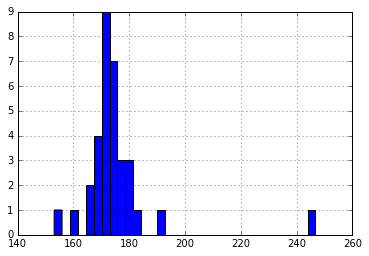

In [72]:
%matplotlib inline
hw_df["height"].hist(bins=hw_df.shape[0])
hw_df["height"].quantile([.05,.95])

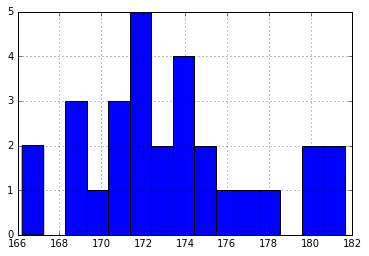

In [76]:
hl = hw_df["height"].quantile([.95])
ll = hw_df["height"].quantile([.05])
hw_df["height"][(hw_df["height"] < hl.iloc[0]) & (hw_df["height"] > ll.iloc[0])].hist(bins=15)

0.05    47.246235
0.95    72.658970
Name: weight, dtype: float64

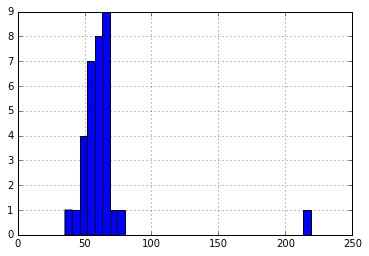

In [163]:
hw_df["weight"].hist(bins=hw_df.shape[0])
hw_df["weight"].quantile([.05,.95])

## Correction

### Simple transformation

We can transform data based on two dataset labels.

In the following dataset there's an error, and variable a has to be the double for observations labelled as b in variable b

In [193]:
df1 = pd.DataFrame({"a":[1,2,3,4,5],"b":["a","a","a","b","b"]})

s1 =pd.Series([1,2],index=["a","b"])
f = s1[pd.match(df1.b,s1.index)]

f.index = df1.index

df1.a * f

0     1
1     2
2     3
3     8
4    10
dtype: int64

This technique can be useful for example when dealing with different units in a same variable. It is also useful for imputation.

Imagine that in sacramento estate csv, somebody tells you that Residential houses the unit is in square meters, instead of square feet.

A fast technique for transforming this is using match.

In [231]:
df = pd.read_csv("../data/Sacramentorealestatetransactions.csv")

conv = pd.Series([1],index=df.type.unique(),dtype=float)
conv["Residential"] = 0.092903

conv[pd.match(df.type,conv.index)].index == df.type
new_factor = conv[pd.match(df.type,conv.index)]
new_factor.index = df.index

(df.sq__ft * new_factor).head()

0     77.666908
1    108.417801
2     73.950788
3     79.153356
4     74.043691
dtype: float64

## Imputation

Imputation is the process of estimating or deriving values for fields where data is missing. 

There is a vast body of literature on imputation methods and it goes beyond the scope of this course to discuss all of them.

Here, we will use pandas to calculate values to impute and assign them to empty values.

In [1]:
import pandas as pd
import numpy as np

df = pd.DataFrame({"a":[0.8,0.4,1.8,np.nan],
                   "b":[2.3,np.nan,np.nan,5.6],
                   "c":[2.4,3.2,1.1,4.5],
                   "d":[np.nan,4.4,1.8,np.nan],
                   "tag":["a","a","b","b"]})

print df.fillna(0)

df.iloc[:,0:4].apply(np.mean)

     a    b    c    d tag
0  0.8  2.3  2.4  0.0   a
1  0.4  0.0  3.2  4.4   a
2  1.8  0.0  1.1  1.8   b
3  0.0  5.6  4.5  0.0   b


a    1.00
b    3.95
c    2.80
d    3.10
dtype: float64

A more drastic approach would be to get rid of these observations or variables that contain an nan.

In [79]:
import pandas as pd
import numpy as np

df = pd.DataFrame({"a":[0.8,0.4,1.8,np.nan],
                   "b":[2.3,np.nan,np.nan,5.6],
                   "c":[2.4,3.2,1.1,4.5],
                   "d":[np.nan,4.4,1.8,np.nan],
                   "tag":["a","a","b","b"]})
print df.dropna(axis=0)
print df.dropna(axis=1)

Empty DataFrame
Columns: [a, b, c, d, tag]
Index: []
     c tag
0  2.4   a
1  3.2   a
2  1.1   b
3  4.5   b


### Basic Imputation Methods

The first is imputation of the mean:

$$ \hat{x}_i = \bar{x}$$
where the $\bar{x}$ is the imputation value and the mean is taken over the observed values. 

The usability of this model is limited since it obviously causes a bias in measures of spread, estimated from the sample after imputation. 

In principle one can use other measures of centrality. For example, imputation of the mean or median can be done as follows.

In [53]:
df = pd.read_csv("../data/iqsize_clean.csv")

#to check where is a null
nulls = df.isnull().sum(axis=1)

# to see whic columns have nans
print df.isnull().sum()

df = df.fillna(df.mean())

df[nulls == 1]

id        0
piq       1
brain     0
height    1
weight    0
sex       1
dtype: int64


,id,piq,brain,height,weight,sex
20,20,134.000000,79.06,62.000000,122,NaN
34,34,111.002703,94.94,70.500000,144,Female
36,36,74.000000,93.00,64.378378,148,Female


We have a dicotomic variable, why don't we provide the mean of the sex gender?

In [30]:
df.pivot_table(index="sex",values=["piq","brain","height","weight"],aggfunc=np.mean)

,brain,height,piq,weight
sex,,,,
Female,82.300952,68.894208,103.957272,154.714286
Male,91.996250,58.600000,118.812500,136.750000


How to fill it?

In [54]:
df = pd.read_csv("../data/iqsize_clean.csv")


sex_means = df.pivot_table(index="sex",values=["piq","brain","height","weight"],aggfunc=np.mean)

df.loc[(df.sex=="Female") & (df.piq.isnull()),"piq"] = sex_means.loc["Female","piq"]
df.loc[(df.sex=="Female") & (df.piq.isnull()),"height"] = sex_means.loc["Female","height"]